In [1]:
import glob

import pandas as pd
import seaborn as sns
from google.api_core.path_template import expand
from matplotlib import pyplot as plt
import glob
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
def compute_stats(y_true, y_pred):
    # y_true = group["LAI"]
    # y_pred = group["LAI_est"]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    # return pd.Series({"RMSE": rmse, "R2": r2, "Bias": bias})
    return rmse, r2, bias

def compute_stats_group(group):
    y_true = group["LAI"]
    y_pred = group["LAI_est"]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    # return pd.Series({"RMSE": rmse, "R2": r2, "Bias": bias})
    return rmse, r2, bias

In [14]:
# bands_data_melt
path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Landsat8_description.csv'

band_info = pd.read_csv(path)
band_info = band_info.astype({'Central Wavelength (nm)': float})
# data_example_melt = pd.merge(band_info, data_prosail_melt, on='band')
band_info = band_info[['band', 'Central Wavelength (nm)']]
print(band_info)

  band  Central Wavelength (nm)
0   B1                   442.96
1   B2                   482.04
2   B3                   561.41
3   B4                   654.59
4   B5                   864.67
5   B6                  1608.86
6   B7                  2200.73


# Validation Random Forest Prosail

# Validation RF

C:\Users\mqalborn\AppData\Local\Temp\ipykernel_23052\2696367187.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_by_date = data_RF_val_tot.groupby("date").apply(compute_stats_group).reset_index()


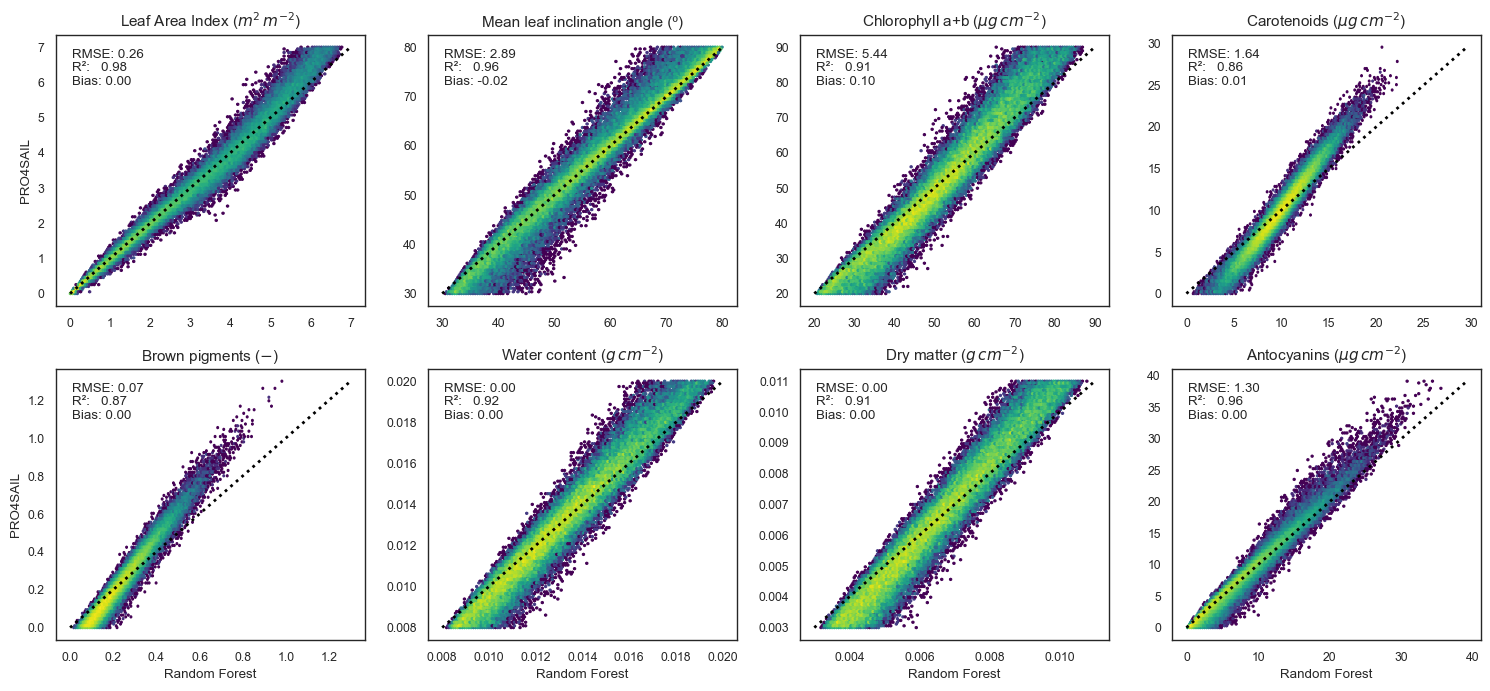

In [19]:
satellite = 'L08'
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\results\validation_prosail/{satellite}'
paths = glob.glob(f'{folder}/*.csv')
data_RF_val_tot = [pd.read_csv(path) for path in paths]
data_RF_val_tot = pd.concat(data_RF_val_tot)
stats_by_date = data_RF_val_tot.groupby("date").apply(compute_stats_group).reset_index()

data_RF_val = [pd.read_csv(path).sample(n=1000) for path in paths]
data_RF_val = pd.concat(data_RF_val)

sns.set_context("paper")
sns.set_style("white")
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7))
axs_flatted = axs.flatten()
var = ['LAI', 'leaf_angle', 'Cab', 'Car', 'Cbrown', 'Cw', 'Cm', 'Ant']
PARAM_PROPS = {"Cab": ["Chlorophyll a+b", r"$\mu g\,cm^{-2}$", 1],
               "Car": ["Carotenoids", r"$\mu g\,cm^{-2}$", 1],
               "Cm": ["Dry matter", r"$g\,cm^{-2}$", 3],
               "Cw": ["Water content", r"$g\,cm^{-2}$", 3],
               "Ant": ["Antocyanins", r"$\mu g\,cm^{-2}$", 1],
               "Cbrown": ["Brown pigments", r"$-$", 1],
               "LAI": ["Leaf Area Index", r"$m^{2}\,m^{-2}$", 2],
               "leaf_angle": ["Mean leaf inclination angle", r"º", 1]}

# fig.supxlabel("Estimated")
# fig.supylabel("Observed")

for x in range(0, len(var)):
    # print(var[x])
    name, unit, decs = PARAM_PROPS[var[x]]

    ax = axs_flatted[x]
    y_true = data_RF_val[var[x]]
    y_pred = data_RF_val[var[x] + '_est']

    # fig, ax = plt.subplots(figsize=(5,5))
    ax.hexbin(y_pred, y_true, gridsize=120, bins='log', cmap='viridis', mincnt=1)
    # plt.scatter(x, y,  s=4, alpha=0.15)
    vmin = np.min([y_pred, y_true])
    vmax = np.max([y_pred, y_true])
    ax.plot([vmin, vmax], [vmin, vmax],  linestyle=':', color='k', lw=2)
    rmse, r2, bias = compute_stats(y_true, y_pred)
    txt_template = (
        f"RMSE: {rmse:.2f}\n"
        f"R²:   {r2:.2f}\n"
        f"Bias: {bias:.2f}"
    )

    ax.text(0.05,
             0.95, txt_template,
             va="top",transform=ax.transAxes)

    ax.set_title(f"{name} ({unit})",  fontsize=11)

    # txt_template = (
    #     f"RMSE: {rmse:.2f} ± {rmse_std:.2f}\n"
    #     f"R²:   {R2:.2f} ± {R2_std:.2f}\n"
    #     f"Bias: {bias:.2f} ± {bias_std:.2f}"
    # )
    # plt.show()
# axs[0, 0].set(xlabel='Machine Learning', ylabel='PRO4SAIL')
[x.set(ylabel='PRO4SAIL') for x in axs[:, 0]]
[x.set(xlabel='Random Forest') for x in axs[1, :]]
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.savefig(rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/validation_RF_PRO4SAIL_{satellite}.jpg', dpi=300)

# Feature Importance

In [16]:
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\results\feature_importance_prosail/{satellite}'
paths = glob.glob(f'{folder}/*.csv')
data_FI = [pd.read_csv(path) for path in paths[0:4]]
data_FI = pd.concat(data_FI).drop('Unnamed: 0', axis=1)

data_FI = pd.merge(band_info, data_FI)
data_FI['Central Wavelength (nm)'] = data_FI['Central Wavelength (nm)'].astype(str)
print(data_FI)

   band Central Wavelength (nm)       Cab       Car        Cm        Cw  \
0    B2                  482.04  0.204497  0.210237  0.169323  0.182463   
1    B2                  482.04  0.212338  0.205038  0.172351  0.202426   
2    B2                  482.04  0.205853  0.202410  0.155236  0.198404   
3    B2                  482.04  0.192880  0.202681  0.161037  0.187499   
4    B3                  561.41  0.135477  0.154527  0.083940  0.067089   
5    B3                  561.41  0.145357  0.156765  0.082288  0.071004   
6    B3                  561.41  0.150119  0.159211  0.087395  0.075874   
7    B3                  561.41  0.163899  0.163072  0.093247  0.068863   
8    B4                  654.59  0.321037  0.201564  0.114099  0.130231   
9    B4                  654.59  0.329779  0.187508  0.102881  0.110303   
10   B4                  654.59  0.293334  0.185015  0.113747  0.109226   
11   B4                  654.59  0.266845  0.187415  0.130578  0.121993   
12   B5                  

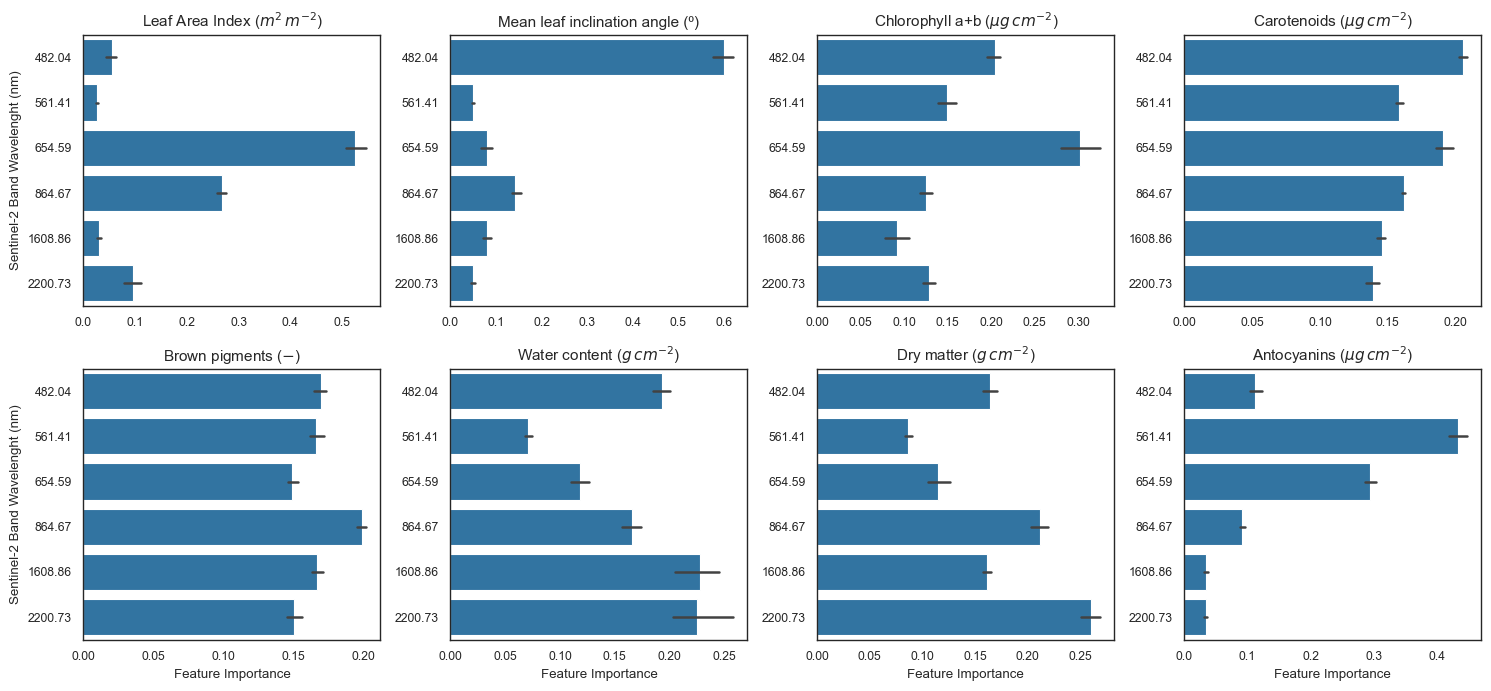

In [18]:
vars = ['LAI', 'leaf_angle', 'Cab', 'Car', 'Cbrown', 'Cw', 'Cm', 'Ant']
PARAM_PROPS = {"Cab": ["Chlorophyll a+b", r"$\mu g\,cm^{-2}$", 1],
               "Car": ["Carotenoids", r"$\mu g\,cm^{-2}$", 1],
               "Cm": ["Dry matter", r"$g\,cm^{-2}$", 3],
               "Cw": ["Water content", r"$g\,cm^{-2}$", 3],
               "Ant": ["Antocyanins", r"$\mu g\,cm^{-2}$", 1],
               "Cbrown": ["Brown pigments", r"$-$", 1],
               "LAI": ["Leaf Area Index", r"$m^{2}\,m^{-2}$", 2],
               "leaf_angle": ["Mean leaf inclination angle", r"º", 1]}

# fig.supxlabel("Estimated")
# fig.supylabel("Observed")
sns.set_context("paper")
sns.set_style("white")
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 7))
axs_flatted = axs.flatten()

for x in range(0, len(vars)):
    ax = axs_flatted[x]
    var = vars[x]
    name, unit, decs = PARAM_PROPS[vars[x]]

    # y_pred = data_RF_val[vars[x] + '_est']
    sns.barplot(data=data_FI, x=var, y='Central Wavelength (nm)', ax=ax)
    ax.set_title(f"{name} ({unit})",  fontsize=11)
    ax.set(ylabel=None, xlabel=None)

[x.set(ylabel='Sentinel-2 Band Wavelenght (nm)') for x in axs[:, 0]]
[x.set(xlabel='Feature Importance') for x in axs[1, :]]
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.savefig(rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/feature_importance_RF_PRO4SAIL_{satellite}.jpg', dpi=300)

# Time series LAI-PROSAIL

In [ ]:
df_lai_prosail_BLS = pd.read_csv(rf'C:\Users\mqalborn\Desktop\ET_3SEB\results/LAI/LAI_S2_BLS.csv')
df_lai_prosail_BLS.drop('Unnamed: 0', axis=1).head()
df_lai_prosail_BLS.loc[:, 'date'] = pd.to_datetime(
    df_lai_prosail_BLS.id.str.split('_', expand=True)[1].str.split('T', expand=True)[0]
)

df_lai_prosail_RIP = pd.read_csv(rf'C:\Users\mqalborn\Desktop\ET_3SEB\results/LAI/LAI_S2_RIP720.csv')
df_lai_prosail_RIP.drop('Unnamed: 0', axis=1).head()
df_lai_prosail_RIP.loc[:, 'date'] = pd.to_datetime(
    df_lai_prosail_RIP.id.str.split('_', expand=True)[1].str.split('T', expand=True)[0]
)

sns.set_context("paper")
sns.set_style("white")
sns.set_palette(['#C9A77B', '#658A6E'])
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

g = sns.lineplot(data=df_lai_prosail_BLS, x='date', y='LAI', hue='block', marker='o', ax=axs[0])

axs[0].text(0.02, 0.95, '(a)', va="top",transform=axs[0].transAxes)
axs[0].legend(title='Treatment')

order = [721, 722, 723, 724]
g1 = sns.lineplot(data=df_lai_prosail_RIP,
                 x='date', y='LAI', hue='block', marker='o', hue_order=order,
                 palette=['#C9A77B', '#A88C6C', '#658A6E', '#91BA8D'] )
g1.set(xlabel='Date', ylabel='LAI S2 PRO4SAIL')
axs[1].text(0.02, 0.95, '(a)', va="top",transform=axs[1].transAxes)

_ = [x.set(xlabel='Date', ylabel='LAI S2 PRO4SAIL') for x in [g, g1]]
_ = [x.legend(title='Treatment') for x in axs.flatten()]

plt.tight_layout()
plt.savefig(rf'C:\Users\mqalborn\Desktop\ET_3SEB\figures/LAI_S2_PROSAIL.jpg', dpi=300)
plt.show()

# Interactive Graphs

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

def read_csv(path):
    bands_data = pd.read_csv(path)
    bands_data = bands_data[bands_data.columns[~bands_data.columns.str.contains('std')]]
    bands_data.loc[:, 'date'] = pd.to_datetime(bands_data.id.str.split('T', expand=True)[0])

    path = 'C:/Users/mqalborn/Desktop/ET_3SEB/Sentinel2_description.csv'
    band_info = pd.read_csv(path)
    band_info = band_info.astype({'Central Wavelength (nm)': int})

    bands_data_melt = bands_data.melt(id_vars=["id", "block", 'date'],
            var_name="band",
            value_name="rho")
    bands_data_melt = pd.merge(band_info, bands_data_melt, on='band')
    return bands_data, bands_data_melt


def plot_scroll_with_static(dynamic_df, static_df,
                            x='Central Wavelength (nm)', y='rho',
                            color='block', static_group='LAI_CLASS'):
    # --- make sure x is numeric and everything is sorted ---
    for df in (dynamic_df, static_df):
        df[x] = pd.to_numeric(df[x], errors='coerce')

    # collapse duplicates per (static_group, x) and sort by x
    static_clean = (static_df
                    .dropna(subset=[x, y])
                    .groupby([static_group, x], as_index=False)[y].mean()
                    .sort_values([static_group, x]))

    # --- animated figure ---
    fig = px.line(dynamic_df, x=x, y=y, color=color, animation_frame='date',
                  width=900, height=520,
                  labels={x: "Central Wavelength (nm)", y: "rho"})

    # consistent axes for both dynamic and static
    xmax = max(dynamic_df[x].max(), static_clean[x].max())
    xmin = min(dynamic_df[x].min(), static_clean[x].min())
    ymax = max(dynamic_df[y].max(), static_clean[y].max())
    fig.update_xaxes(range=[xmin, 2500])
    fig.update_yaxes(range=[0, ymax * 1.15])

    # snappy scrubbing
    if fig.layout.updatemenus:
        fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 0
        fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = 0

    # --- add static reference lines (one per LAI_CLASS) ---
    for g, gdf in static_clean.groupby(static_group):
        fig.add_trace(
            go.Scatter(
                x=gdf[x], y=gdf[y],
                mode="lines",
                name=f"LAI {g}",
                line=dict(dash="dash", width=2),
                opacity=0.8,
                hovertemplate=f"{static_group}: {g}<br>{x}=%{{x}}<br>{y}=%{{y}}<extra>LAI</extra>",
                connectgaps=False,   # don’t bridge missing wavelengths
            )
        )

    fig.update_layout(
        legend=dict(
            title="Legend",
            orientation="v",         # vertical legend (use "h" for horizontal)
            x=1.02,                  # move legend to the right
            y=0.5,
            bgcolor="rgba(0,0,0,0)", # transparent background
            bordercolor="black",
            borderwidth=1
        )
    )
    # optional: put static lines behind
    # for t in fig.data[-len(static_clean[static_group].unique()):]:
    #     t.update(legendgroup="static")

    # fig.show()
    return fig

In [ ]:
path = 'C:/Users/mqalborn/Desktop/ET_3SEB/results/spectral_signature/SS_S2_BLS.csv'
bands_data, bands_data_melt = read_csv(path)
bands_data_melt = bands_data_melt * 0.0001

print(bands_data_melt.columns)
plt.figure(figsize=(8, 5))
g1 = sns.lineplot(data=bands_data_melt, x='Central Wavelength (nm)', y='rho', marker='o')
g1.set(xlim=(400, 2500), ylim=(0, 0.5), xlabel='Sentinel-2 Central Wavelength (nm)', ylabel='Reflectance')

C:\Users\mqalborn\AppData\Local\Temp\ipykernel_30436\1374442198.py:12: FutureWarning: The provided callable <function mean at 0x0000023E456A9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_apogee = data_apogee.groupby(['date', 'hour']).agg(NIR_UP=('NIR_UP', np.mean),
C:\Users\mqalborn\AppData\Local\Temp\ipykernel_30436\1374442198.py:12: FutureWarning: The provided callable <function mean at 0x0000023E456A9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_apogee = data_apogee.groupby(['date', 'hour']).agg(NIR_UP=('NIR_UP', np.mean),


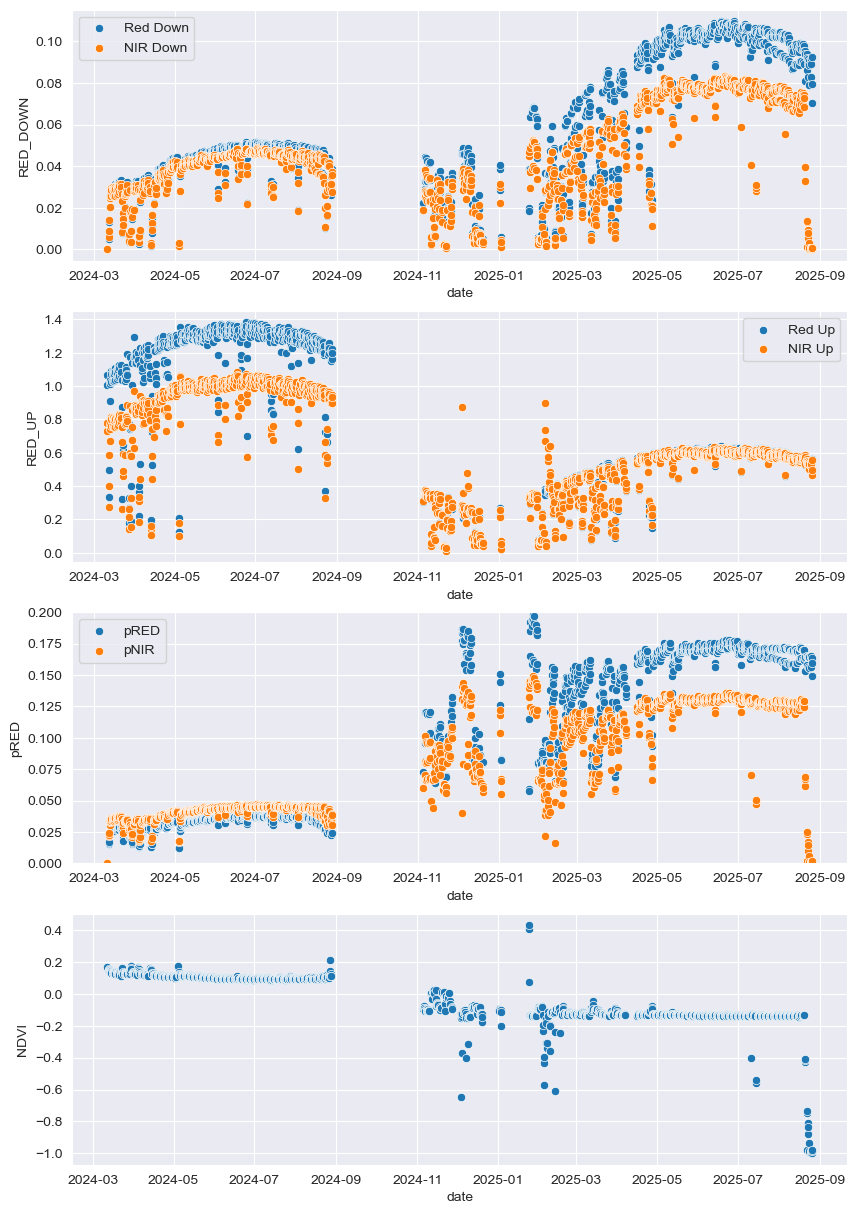

In [88]:
import datetime
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\FLUX\BLS'
paths = glob.glob(folder + '/*.csv')

data_apogee = pd.read_csv(paths[0])
data_apogee = data_apogee[['TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN']]
data_apogee.TIMESTAMP = pd.to_datetime(data_apogee.TIMESTAMP.str[:19], format='%Y-%m-%d %H:%M:%S')
data_apogee.loc[:, 'date'] = data_apogee.TIMESTAMP.dt.date
data_apogee.loc[:, 'hour'] = data_apogee.TIMESTAMP.dt.hour
data_apogee = data_apogee[data_apogee.hour.isin([11,12,13])]

data_apogee = data_apogee.groupby(['date', 'hour']).agg(NIR_UP=('NIR_UP', np.mean),
                                                   RED_UP=('RED_UP', np.mean),
                                                   NIR_DOWN=('NIR_DOWN', np.mean),
                                                   RED_DOWN=('RED_DOWN', np.mean)).reset_index()
data_apogee = data_apogee[(data_apogee.NIR_UP>0) & (data_apogee.NIR_UP<20)]

con = data_apogee.date > datetime.date(2024, 11, 1)
# print(pd.unique(con))
data_apogeev2 = data_apogee.copy()
data_apogeev2.loc[con, 'NIR_UP'] = data_apogee[con]['NIR_DOWN']
data_apogeev2.loc[con, 'NIR_DOWN'] = data_apogee[con]['NIR_UP']

data_apogeev2.loc[con, 'RED_UP'] = data_apogee[con]['RED_DOWN']
data_apogeev2.loc[con, 'RED_DOWN'] = data_apogee[con]['RED_UP']
# data_apogee = data_apogee[con]
data_apogee = data_apogeev2

# sns.scatterplot(data=data_apogee, y='NIR_DOWN', x='date')

data_apogee.loc[:, 'pNIR'] = data_apogee.NIR_DOWN / data_apogee.NIR_UP
data_apogee.loc[:, 'pRED'] = data_apogee.RED_DOWN / data_apogee.RED_UP
data_apogee.loc[:, 'NDVI'] = (data_apogee.pNIR - data_apogee.pRED) / (data_apogee.pNIR + data_apogee.pRED)
data_apogee = data_apogee.reset_index()
#
# print(data_apogee.columns)
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
g1 = sns.scatterplot(data=data_apogee, y='RED_DOWN', x='date', ax=axes[0], label='Red Down')
g1 = sns.scatterplot(data=data_apogee, y='NIR_DOWN', x='date', ax=axes[0], label='NIR Down')
# g1.set_ylim(0, 0.8)
g2 = sns.scatterplot(data=data_apogee, y='RED_UP', x='date', ax=axes[1], label='Red Up')
g2 = sns.scatterplot(data=data_apogee, y='NIR_UP', x='date', ax=axes[1], label='NIR Up')
# g2.set_ylim(0, 1.2)
g3 = sns.scatterplot(data=data_apogee, y='pRED', x='date', ax=axes[2], label='pRED')
g3 = sns.scatterplot(data=data_apogee, y='pNIR', x='date', ax=axes[2], label='pNIR')
g3.set_ylim(0, 0.2)
g3 = sns.scatterplot(data=data_apogee, y='NDVI', x='date', ax=axes[3])
# g3.set_ylim(0, 1)

In [72]:
data_apogee_UP = data_apogee[['date', 'hour', 'NIR_UP', 'RED_UP']]

C:\Users\mqalborn\AppData\Local\Temp\ipykernel_30436\2558608786.py:14: FutureWarning: The provided callable <function mean at 0x0000023E456A9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_apogee2 = data_apogee2.groupby(['date', 'hour']).agg(
C:\Users\mqalborn\AppData\Local\Temp\ipykernel_30436\2558608786.py:14: FutureWarning: The provided callable <function mean at 0x0000023E456A9F30> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data_apogee2 = data_apogee2.groupby(['date', 'hour']).agg(


(0.0, 1.0)

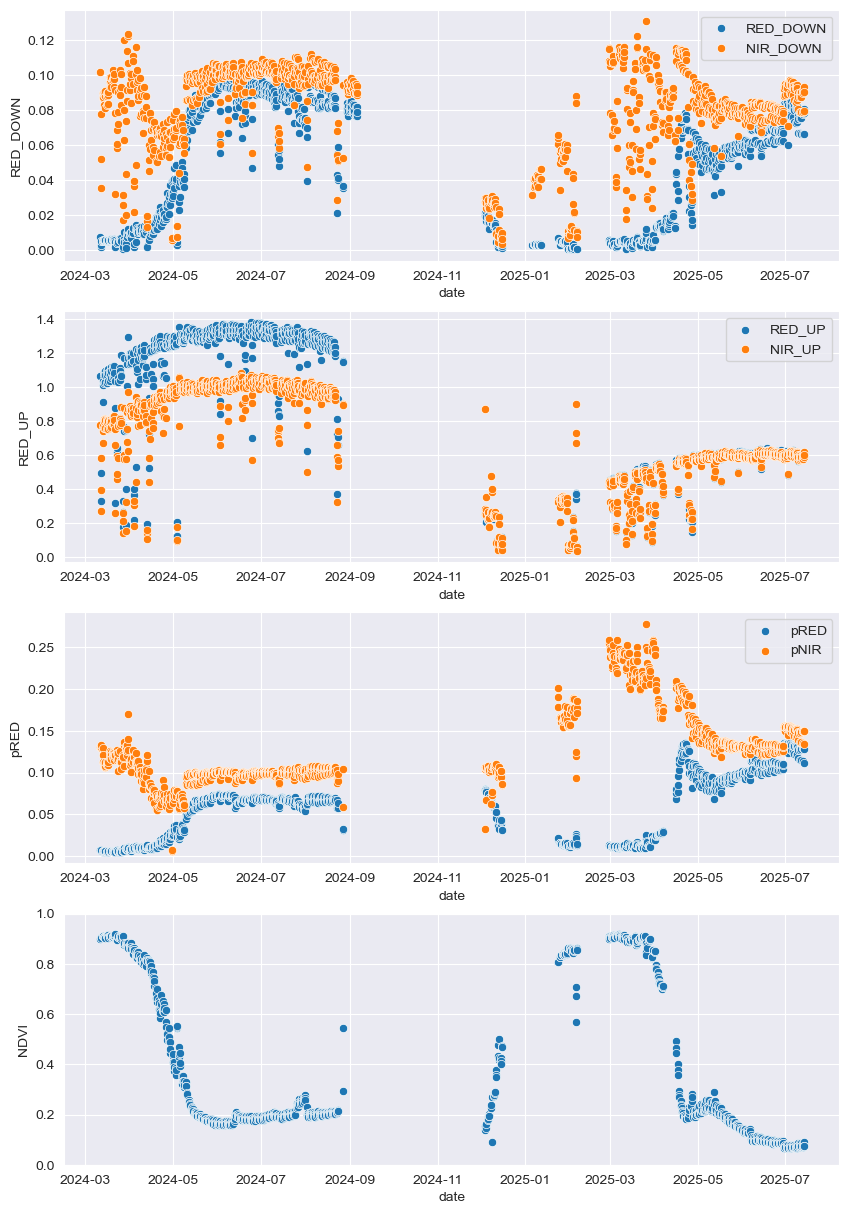

In [87]:
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\FLUX\BLS'
paths = glob.glob(folder + '/*.csv')

data_apogee2 = pd.read_csv(paths[1])
data_apogee2 = data_apogee2[['TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN']]
# data_apogee_1.loc[:, 'block'] = '01'
data_apogee2.TIMESTAMP = pd.to_datetime(data_apogee2.TIMESTAMP.str[:19], format='%Y-%m-%d %H:%M:%S')

data_apogee2.loc[:, 'date'] = data_apogee2.TIMESTAMP.dt.date
data_apogee2.loc[:, 'hour'] = data_apogee2.TIMESTAMP.dt.hour
#
data_apogee2 = data_apogee2[data_apogee2.hour.isin([11,12,13])]
# data_apogee = data_apogee[data_apogee.TIMESTAMP.dt.year == 2024]
data_apogee2 = data_apogee2.groupby(['date', 'hour']).agg(
                                                   NIR_DOWN=('NIR_DOWN', np.mean),
                                                   RED_DOWN=('RED_DOWN', np.mean)
).reset_index()
data_apogee2 = pd.merge(data_apogee2, data_apogee_UP, on=['date', 'hour'], how='left')
# data_apogee2 = data_apogee2[(data_apogee2.NIR_UP>0) & (data_apogee2.NIR_UP<20)]
data_apogee2.loc[:, 'pNIR'] = data_apogee2.NIR_DOWN / data_apogee2.NIR_UP
data_apogee2.loc[:, 'pRED'] = data_apogee2.RED_DOWN / data_apogee2.RED_UP
data_apogee2.loc[:, 'NDVI'] = (data_apogee2.pNIR - data_apogee2.pRED) / (data_apogee2.pNIR + data_apogee2.pRED)
data_apogee2 = data_apogee2.reset_index()

# print(data_apogee.columns)
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
g1 = sns.scatterplot(data=data_apogee2, y='RED_DOWN', x='date', ax=axes[0], label='RED_DOWN')
g1 = sns.scatterplot(data=data_apogee2, y='NIR_DOWN', x='date', ax=axes[0], label='NIR_DOWN')
# g1.set_ylim(0, 0.8)
g2 = sns.scatterplot(data=data_apogee2, y='RED_UP', x='date', ax=axes[1], label='RED_UP')
g2 = sns.scatterplot(data=data_apogee2, y='NIR_UP', x='date', ax=axes[1], label='NIR_UP')
# g2.set_ylim(0, 1.2)
g3 = sns.scatterplot(data=data_apogee2, y='pRED', x='date', ax=axes[2], label='pRED')
g3 = sns.scatterplot(data=data_apogee2, y='pNIR', x='date', ax=axes[2], label='pNIR')
# g3.set_ylim(0, 0.2)
g3 = sns.scatterplot(data=data_apogee2, y='NDVI', x='date', ax=axes[3])
g3.set_ylim(0, 1)


In [ ]:
data_apogee.loc[:, 'pNIR'] = data_apogee.NIR_DOWN / data_apogee.NIR_UP
data_apogee.loc[:, 'pRED'] = data_apogee.RED_DOWN / data_apogee.RED_UP
data_apogee.loc[:, 'NDVI'] = (data_apogee.pNIR - data_apogee.pRED) / (data_apogee.pNIR + data_apogee.pRED)
data_apogee = data_apogee.reset_index()
#
print(data_apogee.columns)
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
g1 = sns.scatterplot(data=data_apogee, y='NIR_DOWN', x='TIMESTAMP', ax=axes[0])
g1.set_ylim(0, 0.8)
g2 = sns.scatterplot(data=data_apogee, y='NIR_UP', x='TIMESTAMP', ax=axes[1])
g2.set_ylim(0, 1.2)
g3 = sns.scatterplot(data=data_apogee, y='pNIR', x='TIMESTAMP', ax=axes[2])
g3.set_ylim(0, 0.2)
g3 = sns.scatterplot(data=data_apogee, y='NDVI', x='TIMESTAMP', ax=axes[3])
g3.set_ylim(0, 1)

Index(['index', 'TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN',
       'hour', 'pNIR', 'pRED', 'NDVI'],
      dtype='object')


(0.0, 1.0)

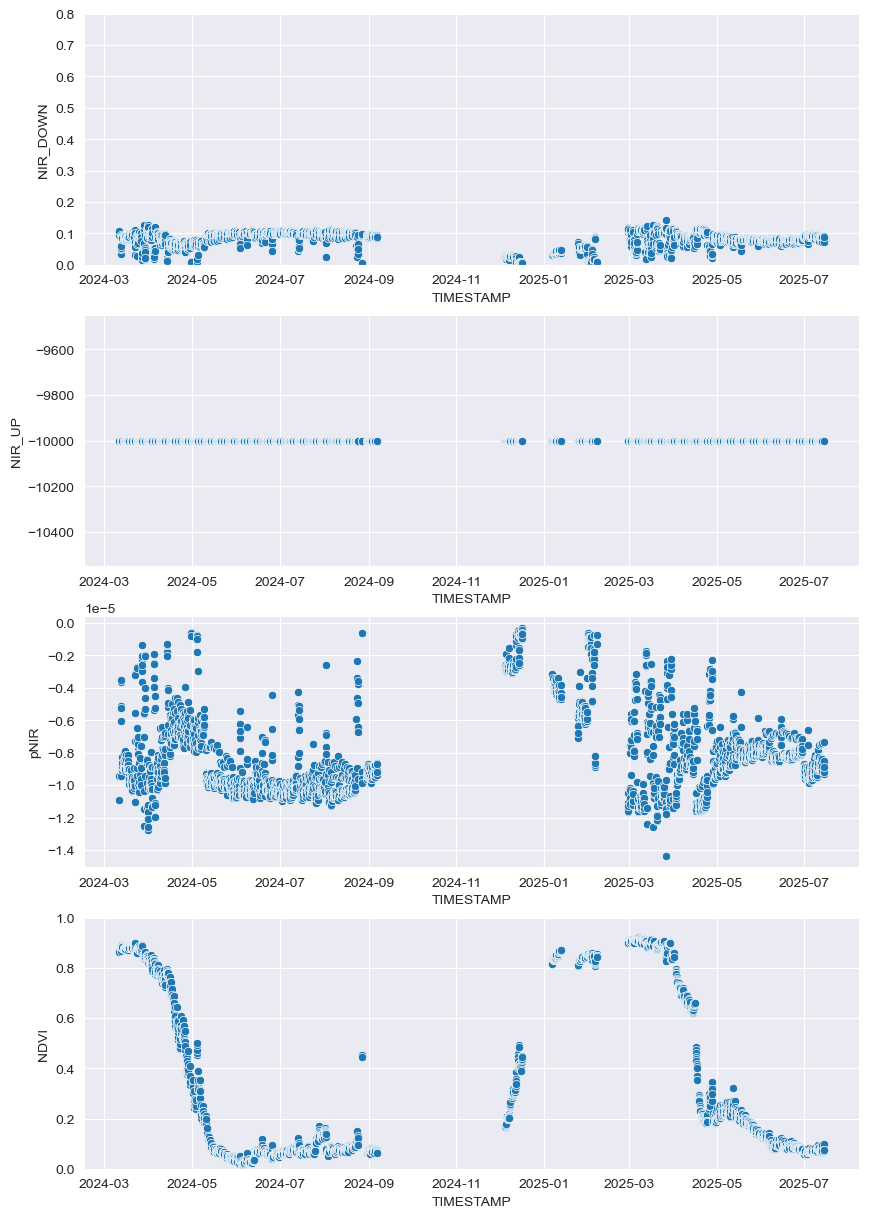

In [13]:
data_apogee = pd.read_csv(paths[1])
data_apogee = data_apogee[['TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN']]
# data_apogee_1.loc[:, 'block'] = '01'
data_apogee.TIMESTAMP = pd.to_datetime(data_apogee.TIMESTAMP.str[:19], format='%Y-%m-%d %H:%M:%S')

# data_apogee.loc[:, 'date'] = data_apogee.TIMESTAMP.dt.date
data_apogee.loc[:, 'hour'] = data_apogee.TIMESTAMP.dt.hour
#
data_apogee = data_apogee[data_apogee.hour.isin([11,12,13])]
# data_apogee = data_apogee[data_apogee.TIMESTAMP.dt.year == 2024]

data_apogee.loc[:, 'pNIR'] = data_apogee.NIR_DOWN / data_apogee.NIR_UP
data_apogee.loc[:, 'pRED'] = data_apogee.RED_DOWN / data_apogee.RED_UP
data_apogee.loc[:, 'NDVI'] = (data_apogee.pNIR - data_apogee.pRED) / (data_apogee.pNIR + data_apogee.pRED)
data_apogee = data_apogee.reset_index()
#
print(data_apogee.columns)
fig, axes = plt.subplots(4, 1, figsize=(10, 15))
g1 = sns.scatterplot(data=data_apogee, y='NIR_DOWN', x='TIMESTAMP', ax=axes[0])
g1.set_ylim(0, 0.8)
g2 = sns.scatterplot(data=data_apogee, y='NIR_UP', x='TIMESTAMP', ax=axes[1])
# g2.set_ylim(0, 1.2)
g3 = sns.scatterplot(data=data_apogee, y='pNIR', x='TIMESTAMP', ax=axes[2])
# g3.set_ylim(0, 0.1)
g3 = sns.scatterplot(data=data_apogee, y='NDVI', x='TIMESTAMP', ax=axes[3])
g3.set_ylim(0, 1)

In [ ]:
folder = rf'C:\Users\mqalborn\Desktop\ET_3SEB\FLUX\BLS'
paths = glob.glob(folder + '/*.csv')

data_apogee_1 = pd.read_csv(paths[0])
data_apogee_1 = data_apogee_1[['TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN']]
data_apogee_1.loc[:, 'block'] = '01'

data_apogee_2 = pd.read_csv(paths[1])
data_apogee_2 = data_apogee_2[['TIMESTAMP', 'NIR_UP', 'RED_UP', 'NIR_DOWN', 'RED_DOWN']]
data_apogee_2.loc[:, 'block'] = '02'
#
# data_apogee = pd.concat([data_apogee_1, data_apogee_2])
#
data_apogee = data_apogee_1
data_apogee.TIMESTAMP = pd.to_datetime(data_apogee.TIMESTAMP.str[:19], format='%Y-%m-%d %H:%M:%S')
#
# data_apogee.loc[:, 'month'] = data_apogee.TIMESTAMP.dt.month
data_apogee.loc[:, 'date'] = data_apogee.TIMESTAMP.dt.date
data_apogee.loc[:, 'hour'] = data_apogee.TIMESTAMP.dt.hour
#
data_apogee = data_apogee[data_apogee.hour.isin([11,12,13])]
data_apogee = data_apogee[data_apogee.TIMESTAMP.dt.year == 2024]

# data_apogee = data_apogee[
    # (data_apogee.TIMESTAMP > pd.Timestamp('2024-07-10'))
    # % (data_apogee.TIMESTAMP < pd.Timestamp('2024-08-10'))
# ]

# data_apogee
data_apogee.loc[:, 'pNIR'] = data_apogee.NIR_DOWN / data_apogee.NIR_UP
data_apogee.loc[:, 'pRED'] = data_apogee.RED_DOWN / data_apogee.RED_UP
data_apogee.loc[:, 'NDVI'] = (data_apogee.pNIR - data_apogee.pRED) / (data_apogee.pNIR + data_apogee.pRED)
data_apogee = data_apogee.reset_index()
#
print(data_apogee.columns)
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
g1 = sns.scatterplot(data=data_apogee, y='NIR_DOWN', x='TIMESTAMP', hue='block', ax=axes[0])
g1.set_ylim(0, 0.8)
g2 = sns.scatterplot(data=data_apogee, y='NIR_UP', x='TIMESTAMP', hue='block', ax=axes[1])
g2.set_ylim(0, 1.2)
g3 = sns.scatterplot(data=data_apogee, y='pNIR', x='TIMESTAMP', hue='block', ax=axes[2])
g3.set_ylim(0, 0.1)


In [ ]:

# data_apogee.block

In [ ]:
print(pd.unique(data_apogee_1.TIMESTAMP.dt.date))

In [ ]:
data_apogee_t = pd.concat([data_apogee_1, data_apogee_2])
data_apogee_t.TIMESTAMP = pd.to_datetime(data_apogee_t.TIMESTAMP.str[:19], format='%Y-%m-%d %H:%M:%S')

# data_apogee.loc[:, 'month'] = data_apogee.TIMESTAMP.dt.month
data_apogee_t.loc[:, 'date'] = data_apogee_t.TIMESTAMP.dt.date
data_apogee_t.loc[:, 'hour'] = data_apogee_t.TIMESTAMP.dt.hour
#
print(pd.unique(data_apogee_t.block))

# data_apogee = data_apogee[data_apogee.hour.isin([11,12,13])]
# data_apogee_t = data_apogee_t[data_apogee_t.TIMESTAMP.dt.year == 2024]
print(pd.unique(data_apogee_t.block))

data_apogee_t = data_apogee_t[
    (data_apogee_t.TIMESTAMP > pd.Timestamp('2024-07-10'))
    # % (data_apogee.TIMESTAMP < pd.Timestamp('2024-08-10'))
]
# print(pd.unique(data_apogee_t.block))

# data_apogee
# data_apogee_t.loc[:, 'pNIR'] = data_apogee_t.NIR_DOWN / data_apogee_t.NIR_UP
# data_apogee_t.loc[:, 'pRED'] = data_apogee_t.RED_DOWN / data_apogee_t.RED_UP
# print(pd.unique(data_apogee_t.block))
data_apogee_t.loc[:, 'NDVI'] = (data_apogee_t.NIR_DOWN - data_apogee_t.RED_DOWN) / (data_apogee_t.NIR_DOWN + data_apogee_t.RED_DOWN)
print(pd.unique(data_apogee_t.block))
plt.figure(figsize=(8, 4))
g1 = sns.scatterplot(data=data_apogee_t, y='NDVI', x='TIMESTAMP', hue='block')
# g1.set_ylim(0, 1)
plt.show()

In [ ]:
data_apogee.TIMESTAMP[7630]

Ploting Sentinel-2 bands stats created from S2_reflectance_analysis

In [ ]:
import os
def read_file_example(path):
    # path = 'C:/Users/mqalborn/Desktop/ET_3SEB/results/PROSAIL_LAI2.csv'
    df = pd.read_csv(path).drop('Unnamed: 0', axis=1)
    df = df[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'LAI']]
    # df.loc[:, 'LAI_CLASS'] = os.path.basename(path).split('_')[2].split('.')[0]
    return df

paths = [
'C:/Users/mqalborn/Desktop/ET_3SEB/results/PROSAIL_LAI.csv'
]
data_prosail = [read_file_example(x) for x in paths]
data_prosail = pd.concat(data_prosail)

con = data_prosail.LAI ==  0.1
data_prosail.loc[con, 'LAI_CLASS'] = 0
con = (data_prosail.LAI >  0.5) & (data_prosail.LAI < 1.5)
data_prosail.loc[con, 'LAI_CLASS'] = 1
con = (data_prosail.LAI >  1.5) & (data_prosail.LAI < 2.5)
data_prosail.loc[con, 'LAI_CLASS'] = 2
con = (data_prosail.LAI >  2.5) & (data_prosail.LAI < 3.5)
data_prosail.loc[con, 'LAI_CLASS'] = 3
con = (data_prosail.LAI >  3.5) & (data_prosail.LAI < 4.5)
data_prosail.loc[con, 'LAI_CLASS'] = 4
# data_example
data_prosail_melt = data_prosail.melt(id_vars=["LAI", "LAI_CLASS"],
    var_name="band",
    value_name="rho")



print(data_example_melt.head())

# Spectral signature of vegetation in BLS

In [ ]:
path = 'C:/Users/mqalborn/Desktop/ET_3SEB/PISTACHIO/results/BLS_BANDS_TS.csv'
bands_data, bands_data_melt = read_csv(path)

plt.figure(figsize=(8, 5))
g1 = sns.lineplot(data=bands_data_melt, x='Central Wavelength (nm)', y='rho', marker='o')
g1.set(xlim=(400, 2500), ylim=(0, 0.5), xlabel='Sentinel-2 Central Wavelength (nm)', ylabel='Reflectance')
# plt.legend(title=False)

# plot_scroll_with_static(bands_data_melt, data_example_melt,
#                             x='Central Wavelength (nm)', y='rho',
#                             color='block', static_group='LAI_CLASS')

# Spectral signature of vegetation in RIPPERDAN

In [ ]:
path = 'C:/Users/mqalborn/Desktop/ET_3SEB/GRAPEX/results/RIP720_BANDS_TS.csv'
bands_data, bands_data_melt = read_csv(path)
plot_scroll_with_static(bands_data_melt, data_example_melt,
                            x='Central Wavelength (nm)', y='rho',
                            color='block', static_group='LAI_CLASS')

In [ ]:
sns.lineplot(data=bands_data_melt, x='Central Wavelength (nm)', y='rho', hue='LAI_CLASS')



Ploting Sentinel-2 bands stats created from S2_reflectance_analysis, RIPERDAN